## Reinforcement Learning Tutorial -2: DQN



```
# This is formatted as code
```

### Author: MD Muhaimin Rahman
contact: sezan92[at]gmail[dot]com

### updated by juanmed on 2022.01.12

In the last tutorial, I tried to explain Q-learning algorithm. The biggest problem with Q-learning is that,it only takes discrete inputs and outputs discrete values. In the Mountain Car problem, we solved this issue by discretizing states which are actually continuous. But this can't be done always. Specially when the states are multidimensional states or images. Deep learning comes here to solve this problem!

For example breakout game by atari

![](https://github.com/sezan92/RLTutorialKeras/blob/master/English/RL%20Tutorial%202/Atari-breakout.jpg?raw=1)

Here , the states are the actual image itself! It is 210x160x3 size RGB numpy array. How will you make discrete for $Q learning$ ? Will that be efficient ? ***NO***! . DQN comes us to save us!

## Intuition

### Deep Q Learning

Q learning is a lookup table problem. i.e. You have the state , you just look at the table and see which action gives you best $Q$ value! That's it. But for continuous state - as mentioned above- you cannot make a lookup table! You need something like a regression model! Which will give you the Q values for given state and action! And the best regression model would be, Deep Neural Network!

So, we will replace the Q table explained in the last tutorial with a Neural Network. i.e. some thing like the following picture

![](https://github.com/sezan92/RLTutorialKeras/blob/master/English/RL%20Tutorial%202/Q2DQN.png?raw=1)

***But there is one little problem!***

In our mountain car problem, we have three discrete actions. $0,1 & 2$ . Using the above architecture, we will have to calculate $Q$ value for each action . Because , you need to take the action with best $Q$ value. To get the action of the best $Q$ value, you need to know the $Q(state,action)$ for each state! So in our case, we will have to run same feed forward process three times!

What if we have more 100 actions ? Will we feed forward 100 times! It is a bit inefficient!! Instead, we will use the following architecture.

![](https://github.com/sezan92/RLTutorialKeras/blob/master/English/RL%20Tutorial%202/NewDQN.png?raw=1)

Meaning, our output layer will calculate $Q$ value for each action. As a result we can calculate Q values in one single forward pass each step! And then we will choose the action with maximum value

#### Bellman Update Equation

In the Original Equation, the bellman update equation is 
\begin{equation}
Q(s_t,a) = Q(s_t,a) + \alpha (Q'(s_{t+1},a)-Q(s_t,a))
\end{equation}

For DQN, we will use similar equation, using Gradient descent
\begin{equation}
\theta_Q \gets \theta_Q - \alpha \frac{\partial}{\partial \theta}(Q'(s_{t+1},a)-Q(s_t,a))^2
\end{equation}

If you are intelligent enough, then you may ask , why there is a squareed part in the gradient descent equation but not in the actual bellman update equation? The reason might be, Mean squared errors are more sensitive to sudden spikes in the target data, which makes it most popular metric for regression models!

### The Concept of Experience Replay

One of the problems in Reinforcment learning is relearning Problem. That is , suppose, in the course of trial and error, one state $s_t$ comes only once or twice, and never comes back. What will happen? There is a chance that the Agent will forget that experience after some time- like us! . So we need to make the agent keep some kind of track of that memory as well. This problem was solved in 1993- yes 26 years ago- by Long Ji lin. In his paper, ***Reinforcement Learning for Robots Using Neural Networks*** , he introduced the concept of Experience Replay. What he did was, he initialized a buffer of a certain size . He stored the experiences of the agent, i.e. state $s_t$, action $a$,next state $s_{t+1}$, reward $r$ . Before training the agent, he you just sample randomly from the buffer . It also helps randomizing the data , which in turn, helps to converge the model faster, as mentioned by Yoshua Bengio in his paper ***Practical Recommendations for Gradient-Based Training of Deep
Architectures***,2012 

### The concept of $\epsilon$-greedy Policy

In the beginning of training, we will have to explore random actions. Because we dont know the value of each action for each state. So we will take some random actions. We will evaluate those actions and see which random action gives us the most rewards. We will try to increase those actions. It means, at first you just ***explore*** different actions , the more you take actions the less you explore and more use your previouse experience to guide you-known as ***exploit***.  This thing can be done using a technique -with another freaking out name- $\epsilon$-greedy policy. 

The big idea is that, we will select a value of $\epsilon$ , suppose $0.9$. Then we will generate a random floating point number . If the generated number is greater than $\epsilon$ we will take action according to the DQN, otherwise a random action. After each episode , we will decrease the value of $\epsilon$ . As a result , in the last episodes, the agent will take actions according to DQN model, not the random actions.

- Set $\epsilon$
- Generate random number $n_{rand}$
- if $n_{rand} < \epsilon$ ***do***
- - take random action
- else ***do***
- - take action according to DQN

### Coding!!

Okay, let's start the most juicy part!

***Importing Libraries***

In [ ]:
import gym
import numpy as np
from collections import deque
import random
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

***Initialization of Environment***

In [ ]:
env = gym.make('MountainCar-v0')

***Hyper parameters***

- ```action_size``` number of actions
- ```actions``` the actions list
- ```gamma``` discount factor $\gamma$
- ```lr``` learning rate $\alpha$
- ```num_episodes``` number of episodes
- ```epsilon``` epsilon , to choose random actions for epsilon greedy policy 
- ```epsilon_decay``` epsilon decay rate
- ```batch_size``` batch size for training

In [ ]:
action_list = [0,1,2]
gamma =0.45
lr =0.001
num_episodes =1000
epsilon =1
epsilon_decay =0.995
memory_size =1000
batch_size=100
show=False
action_size=env.action_space.n
state_size=env.observation_space.shape[0]

In [ ]:
factor=[1,100]

Initializing Replay buffer for ***Experience Replay***

- ```memory``` a deque -which is a special type of list with limited memory- the replay buffer
- ```s``` current state
- ```a``` action
- ```new_s``` new state
- ```r``` reward
- ```d``` terminal
- ```experience``` tuple of state,reward,action,next state


***Psuedocode*** for experience replay

- get initial state $s$
- for each iteration do
- - take a random action $a$
- - get next state $s_{next}$, reward $r$, terminal $d$ 
- - $s \gets s_{next}$
- - if environment is terminated do
- - - reward $\gets$ -100
- - - reset environment
- - - add state,reward,action,next state into replay buffer


In [ ]:
memory=deque(maxlen=memory_size)
s=env.reset()
s = s.reshape((1,-1))
s = s*factor
for _ in range(memory_size):
    a=env.action_space.sample()
    new_s,r,d,_ =env.step(a)
    new_s = new_s.reshape((1,-1))
    new_s = new_s*factor
    if show:
        env.render()
    if d:
        r=-100
        experience =(s,r,a,new_s,d)
        s=env.reset()
        s = s.reshape((1,-1))
    else:    
        experience =(s,r,a,new_s,d)
    memory.append(experience)
    s = new_s
env.close()  

***Model Definition***

Here , I have defined the model as a simple MLP neural network with 2 hidden layers of 100 nodes with ```relu``` activation function

In [ ]:
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(1,state_size)))
model.add(Dense(100,activation='relu'))
model.add(Dense(action_size,activation='linear'))
model.compile(loss='mse',optimizer=Adam(lr=lr),)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1, 100)            300       
                                                                 
 dense_7 (Dense)             (None, 1, 100)            10100     
                                                                 
 dense_8 (Dense)             (None, 1, 3)              303       
                                                                 
Total params: 10,703
Trainable params: 10,703
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Here ,
- ```ep_list``` list of episodes
- ```reward_list``` list of rewards
- ```total_rewards``` totatl reward

***Psuedocode***

- for each episode do
- - get initial state $s$
- -  $rewards_{total} \gets 0 $
- - set terminal $d$ to false 
- - for each step do
- - - choose action based on epsilon greedy policy
- - - get next state $s_{next}$, reward $r$, terminal $d$ doing the action
- - - $rewards_{total} \gets rewards_{total}+r$
- - - if $d$ is $True $ 
- - - - if $rewards_{total}<-199$ 
- - - - - then give punishment $r \gets -100$
- - - - - break 
- - - $s \gets s_{next}$
- - take random samples of $s,r,a,s_{next}$ from replay buffer
- - get $Q(s_{next})$ 
- - $Q_{target} \gets r+\gamma max(Q(s_{next})) $
- - $loss \gets \frac{1}{N}\sum(Q_{target}-Q(s))^2$
- - train the network using this loss

In [7]:
ep_list =[]
reward_list =[] 
index=0 
#oh = OneHotEncoder(3)
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
for ep in range(num_episodes):
    s= env.reset()
    s=s.reshape((1,-1))
    s = s*factor
    total_rewards =0
    d = False
    j = 0
    for j in range(200):
        if np.random.random()< epsilon:
            a = np.random.randint(0,len(action_list))
        else:
            Q = model.predict(s.reshape(-1,s.shape[0],s.shape[1]))
            a =np.argmax(Q)
        new_s,r,d,_ = env.step(a)
        new_s = new_s.reshape((1,-1))
        new_s = new_s*factor
        total_rewards=total_rewards+r
        if show:
            env.render()
        if d:
            if total_rewards<-199:
                r =-100
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Failed! Reward %d"%(ep,total_rewards))
            elif total_rewards<-110 and total_rewards>-199:
                r=10
                d=True
                experience = (s,r,a,new_s,d)
                memory.append(experience)
                print("Episode %d, Better! Reward %d"%(ep,total_rewards))
            elif total_rewards>=-110:
                r=100
                experience = (s,r,a,new_s,d)
                memory.append(experience)

                print("Episode %d, Passed! Reward %d"%(ep,total_rewards))
            ep_list.append(ep)
            reward_list.append(total_rewards)
            break
        
        experience = (s,r,a,new_s,d)
        memory.append(experience)
        if j==199:
            print("Reward %d after full episode"%(total_rewards))
            
        s = new_s
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches])
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    #actions=oh.fit_transform(actions.reshape(-1,1)).toarray()
    actions = ct.fit_transform(actions.reshape(-1,1))
    try:
      actions = actions.reshape(-1,1,action_size)
      new_states= np.array([batch[3] for batch in batches])
      dones= np.array([batch[4] for batch in batches])
      Qs =model.predict(states)
      new_Qs = model.predict(new_states)
      target_Qs=rewards.reshape(-1,1)+gamma*(np.max(new_Qs,axis=2)*(~dones.reshape(-1,1)))
      Qs[actions==1]=target_Qs.reshape(-1,)
      model.fit(states,Qs,verbose=0)
      epsilon=epsilon*epsilon_decay
    except Exception as e:
      print(str(e))
env.close()

Episode 0, Failed! Reward -200
Episode 1, Failed! Reward -200
Episode 2, Failed! Reward -200
Episode 3, Failed! Reward -200
Episode 4, Failed! Reward -200
Episode 5, Failed! Reward -200
Episode 6, Failed! Reward -200
Episode 7, Failed! Reward -200
Episode 8, Failed! Reward -200
Episode 9, Failed! Reward -200
Episode 10, Failed! Reward -200
Episode 11, Failed! Reward -200
Episode 12, Failed! Reward -200
Episode 13, Failed! Reward -200
Episode 14, Failed! Reward -200
Episode 15, Failed! Reward -200
Episode 16, Failed! Reward -200
Episode 17, Failed! Reward -200
Episode 18, Failed! Reward -200
Episode 19, Failed! Reward -200
Episode 20, Failed! Reward -200
Episode 21, Failed! Reward -200
Episode 22, Failed! Reward -200
Episode 23, Failed! Reward -200
Episode 24, Failed! Reward -200
Episode 25, Failed! Reward -200
Episode 26, Failed! Reward -200
Episode 27, Failed! Reward -200
Episode 28, Failed! Reward -200
Episode 29, Failed! Reward -200
Episode 30, Failed! Reward -200
Episode 31, Failed

Text(0, 0.5, 'Rewards')

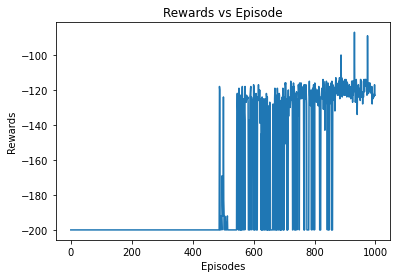

In [8]:
plt.plot(reward_list)
plt.title("Rewards vs Episode")
plt.xlabel("Episodes")
plt.ylabel("Rewards")